# Загрузка Pandas и очистка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re

In [2]:
df = pd.read_csv('main_task.csv')

In [3]:
# Ваш код по очистке данных и генерации новых признаков
# При необходимости добавьте ячейки

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [5]:
dummed_cities = pd.get_dummies(df['City'])
df = df.join(dummed_cities)

In [6]:
# Конвертируем даты в правильный формат
def convert_time(row):
    for pos, date in enumerate(row):
        date = pd.Timestamp(date)
        return date

# Найдём дату последнего отзыва
def last_review(dates):
    date_temp = []
    try:
        for date in dates:
            date = pd.Timestamp(date)
            date_temp.append(date)
        return max(date_temp)
    except:
        return np.nan

# Найдём дату первого отзыва
def first_review(dates):
    date_temp = []
    try:
        for date in dates:
            date = pd.Timestamp(date)
            date_temp.append(date)
        return min(date_temp)
    except:
        return np.nan

In [7]:
# Убираем квадратные скобки
df['Cuisine Style'] = df['Cuisine Style'].str.replace(r'[\[\]]', '')
df['Reviews'] = df['Reviews'].str.replace(r'[\[\]]', '')

# Создаем списки из значений кухонь
def edit_cuisine(row):
    if pd.isnull(row):
        pass
    else:
        return row.split(',')

df['Cuisine Style'] = df['Cuisine Style'].apply(edit_cuisine)

# Содаем новый признак с количеством представленных кухонь
def cuisine_types(row):
    try:
        return len(row)
    except:
        return 1

df['number_of_cuisine_types'] = df['Cuisine Style'].apply(cuisine_types)

In [8]:
def date_catch(row):
    # Создать колонку с датой
    pattern_date = re.compile('\d\d\/\d\d\/\d\d\d\d')
    

In [9]:
# Создать колонку с датой
pattern_date = re.compile('\d\d\/\d\d\/\d\d\d\d')

def catch_date(row):
    result = re.findall(pattern_date, row)
    return result

df['Review_date'] = df['Reviews'].apply(catch_date)

# Создать списки в Reviews
pattern = re.compile('\'(.*?)\'')

def split_reviews(row):
    result = re.findall(pattern, row)
    return result

df['Reviews'] = df['Reviews'].apply(split_reviews)
df['Last Review'] = df['Review_date'].apply(last_review)
df['Last Review'].fillna(df['Last Review'].mean(), inplace=True)
df['First Review'] = df['Review_date'].apply(first_review)
df['First Review'].fillna(df['First Review'].mean(), inplace=True)
df['Reviews Gap'] = df['Last Review'] - df['First Review']
df['Reviews Gap'].fillna(df['Reviews Gap'].mean(), inplace=True)

In [10]:
df['Review_date'].apply(last_review)

0       2017-12-31
1       2017-07-06
2       2018-01-08
3              NaT
4       2017-11-18
           ...    
39995   2017-12-16
39996   2017-12-21
39997   2016-11-03
39998   2017-07-11
39999   2016-01-31
Name: Review_date, Length: 40000, dtype: datetime64[ns]

In [11]:
df['Number of Reviews'] = df['Number of Reviews'].fillna(df['Number of Reviews'].mean())

<AxesSubplot:>

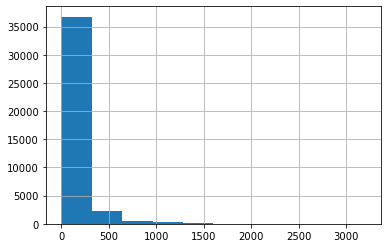

In [12]:
df['Reviews Gap'] = df['Reviews Gap'].dt.days
df['Reviews Gap'].hist()

In [13]:
df['Price Range'].value_counts()

$$ - $$$    18412
$            6279
$$$$         1423
Name: Price Range, dtype: int64

In [14]:
def convert_price(row):
    if row == '$':
        return 1
    elif row == '$$ - $$$':
        return 2
    elif row == '$$$$':
        return 3

In [15]:
df['Price Range Mod'] = df['Price Range'].apply(convert_price)

In [16]:
df['Price Range Mod'].fillna(2, inplace=True)

In [17]:
df = df.drop(['Restaurant_id', 'City', 'Cuisine Style', 'Reviews', 'URL_TA', 'ID_TA', 'Review_date',
             'Price Range', 'First Review', 'Last Review'], axis=1)

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [18]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['Rating'], axis = 1)
y = df['Rating']

In [19]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [20]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [21]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [22]:
RANDOM_SEED = 11

In [23]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [24]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21286149999999998


<AxesSubplot:>

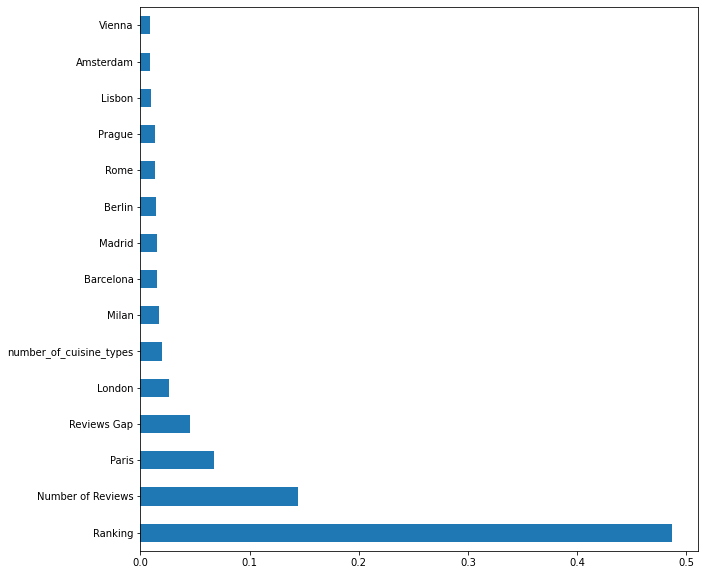

In [25]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Ranking                  40000 non-null  float64
 1   Rating                   40000 non-null  float64
 2   Number of Reviews        40000 non-null  float64
 3   Amsterdam                40000 non-null  uint8  
 4   Athens                   40000 non-null  uint8  
 5   Barcelona                40000 non-null  uint8  
 6   Berlin                   40000 non-null  uint8  
 7   Bratislava               40000 non-null  uint8  
 8   Brussels                 40000 non-null  uint8  
 9   Budapest                 40000 non-null  uint8  
 10  Copenhagen               40000 non-null  uint8  
 11  Dublin                   40000 non-null  uint8  
 12  Edinburgh                40000 non-null  uint8  
 13  Geneva                   40000 non-null  uint8  
 14  Hamburg               